**логистическая регрессия**

нелинейный классификатор,  
метод градиентного спуска



Евгений Борисов borisov.e@solarl.ru

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing   import MinMaxScaler
from sklearn.preprocessing   import PolynomialFeatures

---

In [2]:
def get_seed(): t = time() ; return int(((t%1)/(t//1))*1e11)

In [3]:
# # загружаем даные
# data = [
#     np.loadtxt('../data/200_2b/points_1.txt'),
#     np.loadtxt('../data/200_2b/points_2.txt')
# ]

In [4]:
# загружаем даные
data = [
    np.loadtxt('data/1998_2/points_b.txt'),
    np.loadtxt('data/1998_2/points_r.txt')
]
n_pol=2

In [5]:
# собираем вместе
X_train = np.vstack(data)

n_cls = len(data) # количество классов

n_ex = X_train.shape[0]

# метки классов
y_train = [ [i]*data[i].shape[0] for i in range(n_cls)]
y_train = [ item for sublist in y_train for item in sublist ]
y_train = np.asarray(y_train) # .reshape(n_ex,1)

X_train.shape, y_train.shape

((1998, 2), (1998,))

In [6]:
%xdel data

In [7]:
# нормируем данные
X_train = MinMaxScaler([-1.0,1.0]).fit_transform(X_train)

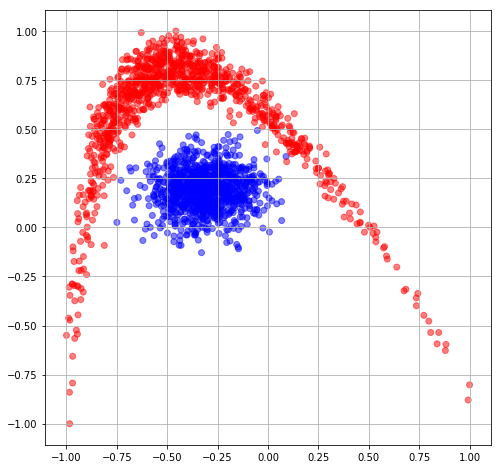

In [8]:
c = [ ['b','r'][int(j>0.5)] for j in y_train  ]
plt.figure(figsize=(8,8))
plt.scatter( x=X_train[:,0], y=X_train[:,1], c=c,  alpha=0.5 )
plt.grid()
plt.show()


---

In [9]:
# собираем полином
poly = PolynomialFeatures(n_pol)
Xp = poly.fit_transform(X_train)
n_par = Xp.shape[1] # количество параметров

Xp.shape

(1998, 6)

In [10]:
def act(z): return 1.0/(1.0 + np.exp(-z))

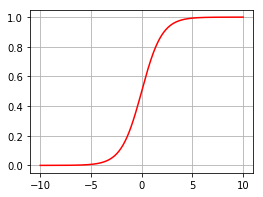

In [11]:
plt.figure(figsize=(4,3))
z=np.linspace(-10,10,500)
plt.plot( z,act(z),'-r' )
plt.grid()
plt.show()

In [12]:
# инициализация параметров
np.random.seed(get_seed())
T = np.random.normal(loc=0.0, scale=0.1, size=n_par)
T

array([ 0.13292122, -0.07700335, -0.03162804, -0.09908104, -0.10708163,
       -0.14387133])

In [13]:
# ф-ция потери - кросс-энтропия
def loss(o,y):
    o_restr = np.minimum(0.99999,np.maximum(1e-9,o))
    return -( y*np.log(o_restr) + (1-y)*np.log(1.0-o_restr) ).sum() / y.shape[0]

In [14]:
# def CrossEntropy(o, y): 
#    return -log(o) if (y == 1)  else -log(1.0 - o)

In [15]:
# метод градиентного спуска

a=0.1 # скорость обучения

MAX_ITER = 500 # максимальное число циклов обучения

MIN_ERROR = 0.01 # порог минимальной ошибки

er_hist = [] # история ошибки

In [16]:
for i in range(MAX_ITER):
    
    O = act(Xp.dot(T)) # выход
    E = O - y_train # ошибка
    
    er_hist.append( loss(O,y_train) ) # значение ф-ции потери     
    
    if er_hist[-1] < MIN_ERROR: # проверяем достижение порога
        print(i,'min error ',er_hist[-1])
        break
    
    dE = (Xp*E.reshape(n_ex,1)).sum(axis=0).reshape(T.shape)
    dE /= np.linalg.norm(dE) # нормируем градиент
    
    T = T - a*dE
   

479 min error  0.009986611615834268


In [17]:
print(T)
print(len(er_hist),er_hist[-1],min(er_hist))

[-7.6888472  17.63015051 10.30634984 34.02287268  8.64744884 20.4690062 ]
480 0.009986611615834268 0.009986611615834268


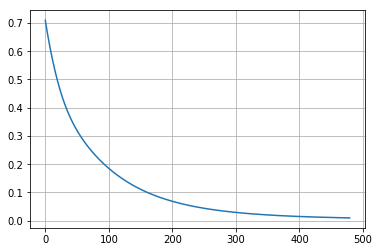

In [18]:
plt.plot(range(len(er_hist)),er_hist)
plt.grid()
plt.show()

---

In [19]:
score_bound=0.5
o = act(Xp.dot(T))

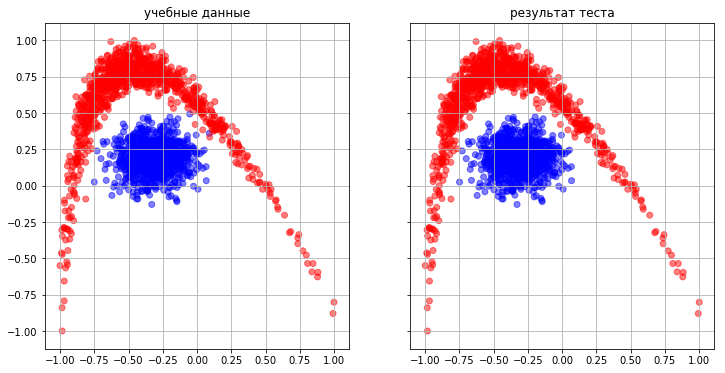

In [20]:
f, axarr = plt.subplots(1,2, sharey=True,figsize=(12,6),)
    
c = [ ['b','r'][int(j>0.5)] for j in y_train  ]
axarr[0].set_title('учебные данные')
axarr[0].scatter( x=X_train[:,0], y=X_train[:,1], c=c,  alpha=0.5 )
axarr[0].grid()

c = [ ['b','r'][int(j>score_bound)] for j in o  ]
axarr[1].set_title('результат теста')
axarr[1].scatter( x=X_train[:,0], y=X_train[:,1], c=c,  alpha=0.5 )
axarr[1].grid()

plt.show()


---

In [21]:
# строим сетку 
# и определяем значения скора классификатора во всех узлах

n=500 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace(-1.1, 1.1, n), 
    np.linspace(-1.1, 1.1, n)
) # узлы сетки

xx.shape, yy.shape

((500, 500), (500, 500))

In [22]:
xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
xy.shape

(250000, 2)

In [23]:
# xy = np.hstack( [ np.ones([n*n,1]) , xy ] )
xy = poly.transform(xy)
p = act(xy.dot(T)).reshape(n,n) # вычисляем скор для каждого узла сетки

In [24]:
c = [ ['b','r'][ int(j>0.5) ] for j in y_train  ]

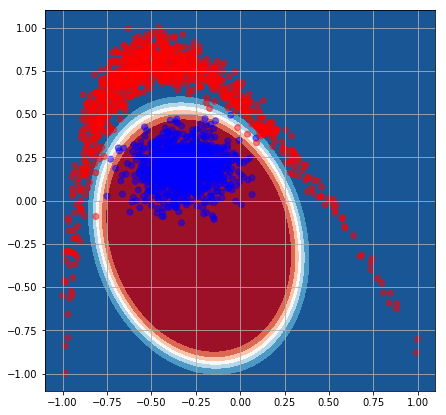

In [25]:
plt.figure(figsize=(7,7))
plt.contourf(xx, yy, p, cmap=plt.cm.RdBu)
plt.scatter( x=X_train[:,0], y=X_train[:,1], c=c, alpha=.5 )
plt.grid()
plt.show()